In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import tensorflow as tf

from IPython.display import display
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import model_from_json

# Train your model...

In [49]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
train_dir = 'data/train'
test_dir = 'data/test'
img_width, img_height = 224, 224


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7500 images belonging to 3 classes.
Found 2850 images belonging to 3 classes.


In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


num_train_samples = train_generator.samples
num_test_samples = test_generator.samples




# Calculate steps per epoch and validation steps
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_test_samples // batch_size

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)
`   


Epoch 1/20
234/234 [==============================] - 161s 680ms/step - loss: 0.1473 - accuracy: 0.9423 - val_loss: 0.6551 - val_accuracy: 0.8564 - lr: 1.0000e-04
Epoch 2/20
234/234 [==============================] - 158s 676ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.0520 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 3/20
234/234 [==============================] - 158s 674ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.2016 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 4/20
234/234 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9933
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
234/234 [==============================] - 161s 688ms/step - loss: 0.0177 - accuracy: 0.9933 - val_loss: 0.1433 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 5/20
234/234 [==============================] - 151s 646ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0554 - val_accuracy: 0.9831 - lr: 2.0000e-05
Epoch 5: early stopping

In [12]:
print("Activation shape:", activation.shape)

Activation shape: (1, 25088)


In [52]:
model.save('model.h5')

1/1 [==============================] - 0s 23ms/step


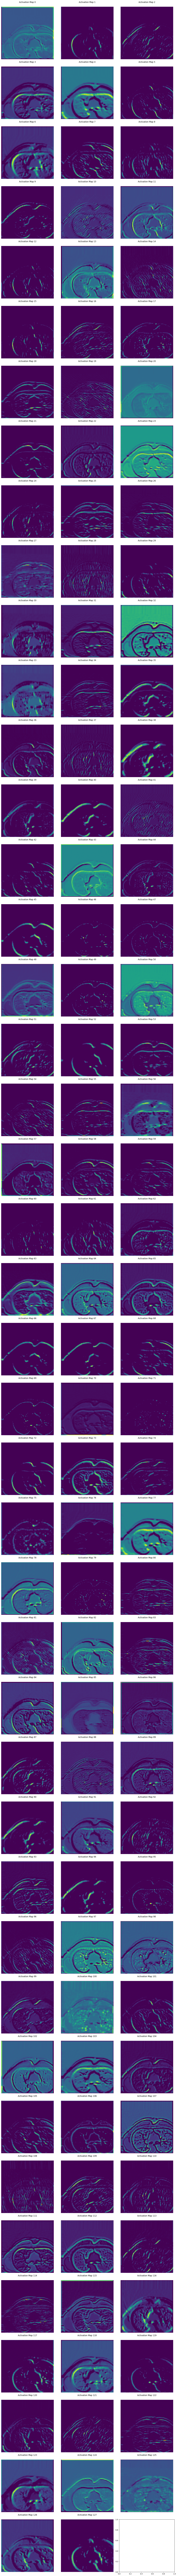

In [20]:
# Get the activations of a specific layer for the input image
layer_index = 5  # Index of the layer you want to access
layer_output = activation_model.predict(img)[layer_index]

# Calculate the number of rows and columns for subplots
num_rows = (layer_output.shape[3] + 2) // 3  # Add 2 to round up to the nearest multiple of 3
num_cols = min(3, layer_output.shape[3])  # Limit to 3 columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Visualize the output of the specific layer
for i in range(num_rows):
    for j in range(num_cols):
        if (i * num_cols + j) < layer_output.shape[3]:
            activation_map = layer_output[0, :, :, i * num_cols + j]
            axes[i, j].matshow(activation_map, cmap='viridis')
            axes[i, j].set_title('Activation Map {}'.format(i * num_cols + j))
            axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 28ms/step


<Figure size 1000x1000 with 0 Axes>

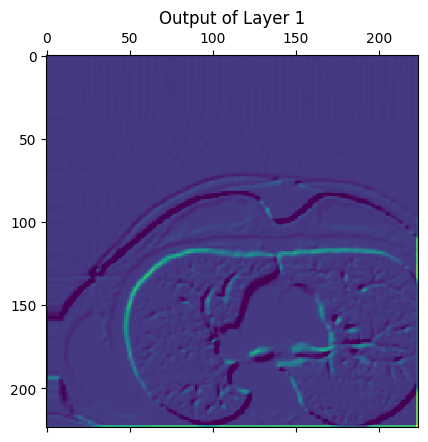

In [18]:
# Get the activations of a specific layer for the input image
layer_index = 1  # Index of the layer you want to access
layer_output = activation_model.predict(img)[layer_index]

# Visualize the output of the specific layer
if len(layer_output.shape) == 2:  # For fully connected layers
    # Reshape the activation to 1D
    activation_reshaped = layer_output.reshape((-1,))
    # Plot the activation values directly
    plt.figure(figsize=(10, 5))
    plt.plot(activation_reshaped)
    plt.title('Output of Layer {}'.format(layer_index))
    plt.xlabel('Activation Index')
    plt.ylabel('Activation Value')
    plt.show()
elif len(layer_output.shape) == 4:  # For convolutional layers
    plt.figure(figsize=(10, 10))
    plt.matshow(layer_output[0, :, :, 0], cmap='viridis')
    plt.title('Output of Layer {}'.format(layer_index))
    plt.show()
else:
    print("Unsupported activation shape for layer", layer_names[layer_index])


1/1 [==============================] - 0s 27ms/step


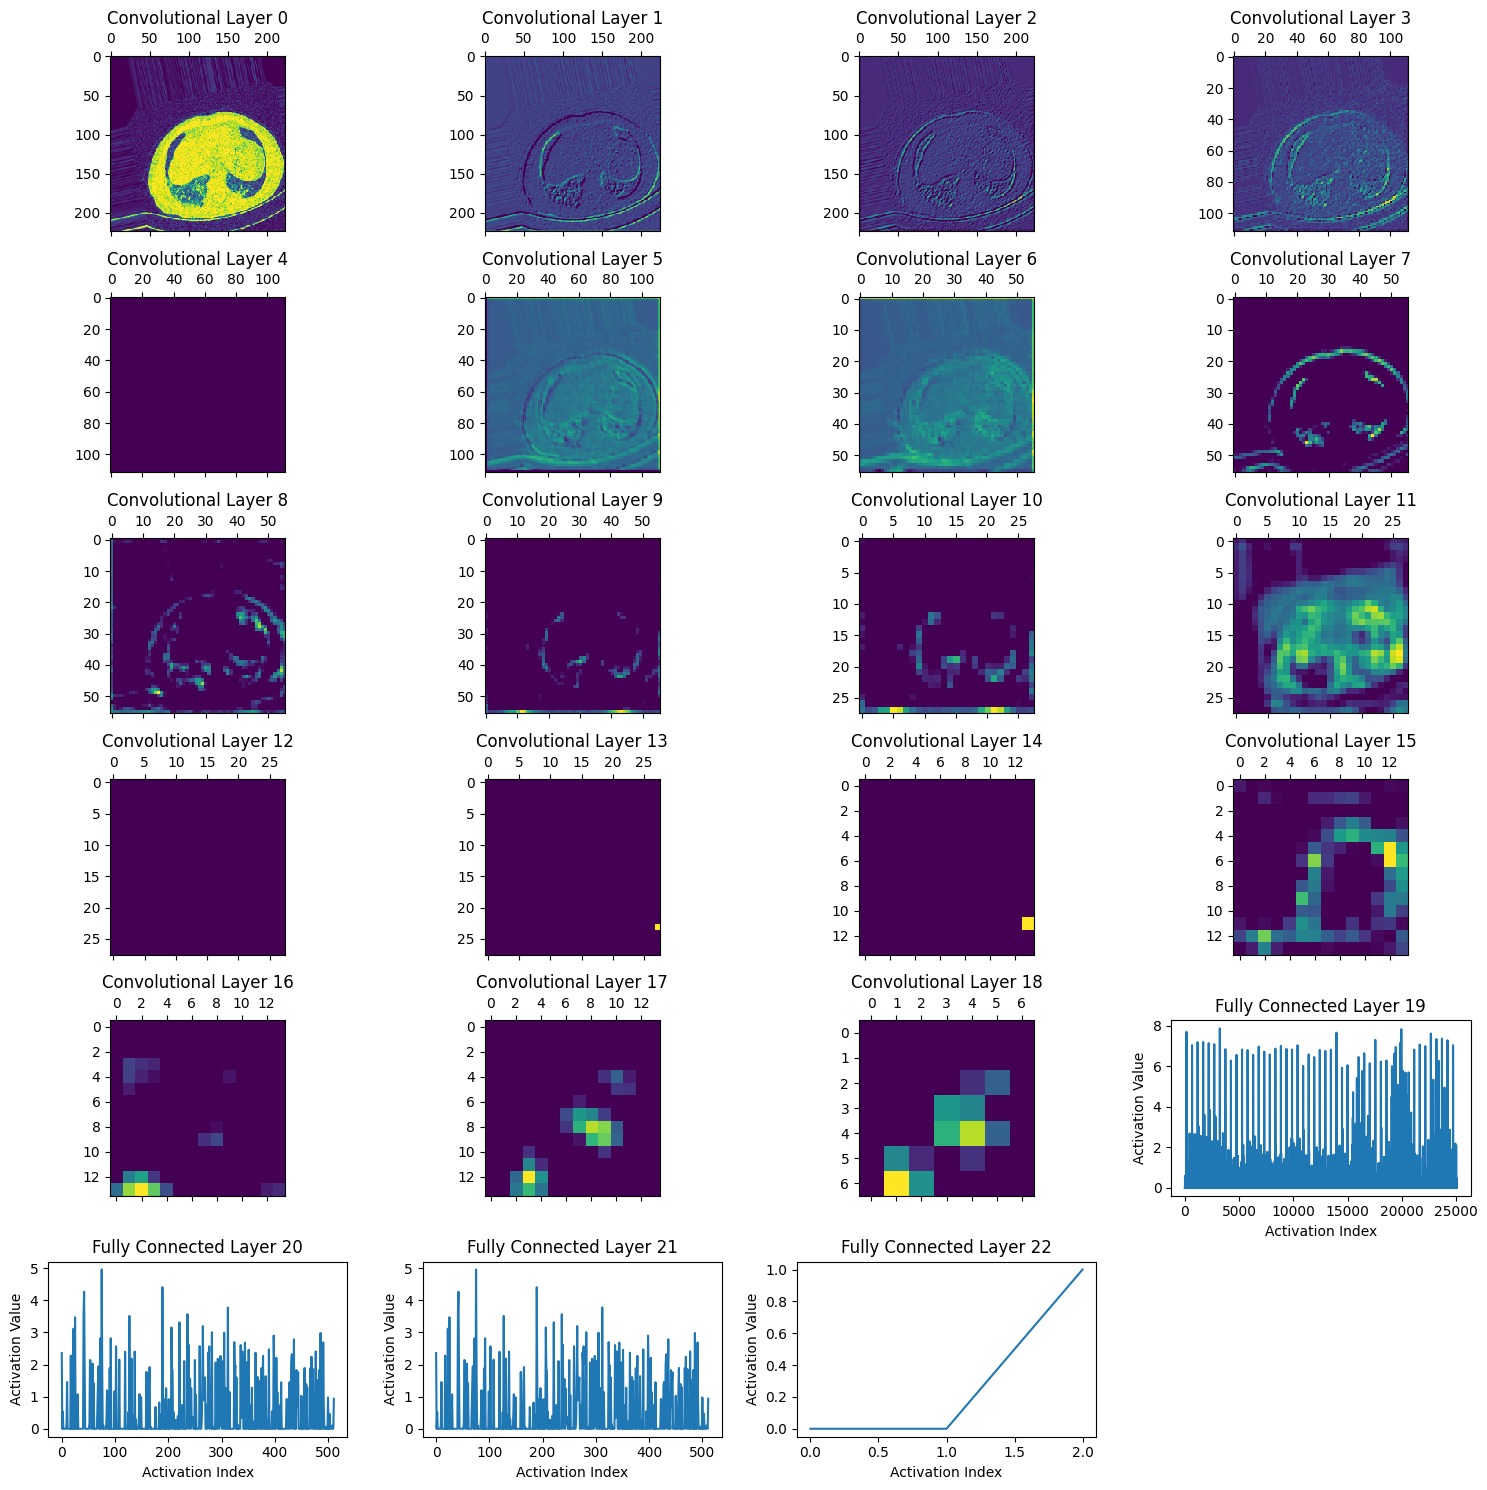

In [21]:
# Load a batch of images and labels from the generator
images, labels = next(train_generator)

# Select the first image from the batch
img = images[0]

# Reshape the image to match the input shape of the model
img = np.expand_dims(img, axis=0)

# Get the activations of all layers for the input image
activations = activation_model.predict(img)

# Get layer names
layer_names = [layer.name for layer in model.layers]

# Calculate the number of rows and columns for subplots
num_layers = len(activations)
num_cols = 4
num_rows = (num_layers + num_cols - 1) // num_cols

# Visualize the output of each layer
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, activation in enumerate(activations):
    if len(activation.shape) == 2:  # For fully connected layers
        # Reshape the activation to 1D
        activation_reshaped = activation.reshape((-1,))
        # Plot the activation values directly
        ax = axes[i // num_cols, i % num_cols]
        ax.plot(activation_reshaped)
        ax.set_title('Fully Connected Layer {}'.format(i))
        ax.set_xlabel('Activation Index')
        ax.set_ylabel('Activation Value')
    elif len(activation.shape) == 4:  # For convolutional layers
        ax = axes[i // num_cols, i % num_cols]
        ax.matshow(activation[0, :, :, 0], cmap='viridis')
        ax.set_title('Convolutional Layer {}'.format(i))
    else:
        print("Unsupported activation shape for layer", layer_names[i])

# Hide any unused subplots
for i in range(num_layers, num_rows * num_cols):
    axes[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()
plt.show()


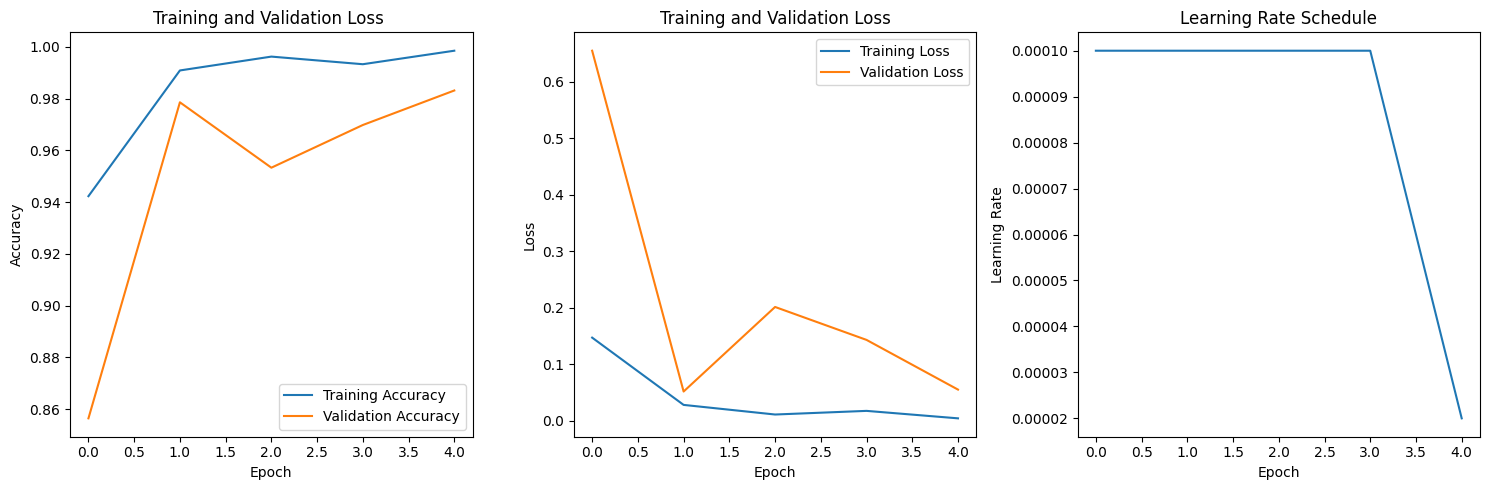

In [47]:
# Plotting accuracy, loss, and learning rate in the same row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Loss ')
axs[0].legend()

# Loss plot
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

# Learning rate plot
axs[2].plot(history.history['lr'])
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')

plt.tight_layout()
plt.show()


In [34]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test accuracy:', test_accuracy)

90/90 [==============================] - 26s 285ms/step - loss: 0.0519 - accuracy: 0.9786
Test accuracy: 0.9785965085029602


In [51]:


# After training, serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_weights.h5")
